# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Forward and reverse differentiation

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [6]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

## 1. Forward differentiation

In [7]:
arr=cp.zeros((2,3,4))
pos = cp.array([True,False,False,True])
arr[...,pos] = 1

Casting output of function zeros from float64 to float32


In [8]:
n=50
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':cp.array([[0.,0.],[0.8,0.7],[0.,0.2]]),
    'seedValues':ad.array([0.*delta[0],0.2*(1.+delta[0]),0.*delta[0]]),
    'exportValues':1,
    'traits':{
        'shape_i':(8,8),'niter_i':16,
    }
    
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

Casting output of function zeros from float64 to float32
Casting output of function array from float64 to float32


In [9]:
#delta1 = ad.Dense.identity(constant=cp.zeros(1))
#cost1 = 1.+delta1[0]*(X[0]>0.1)
hfmIn['cost']=1.+delta[0]*(X[0]>0.) + delta[1]*(X[0]<=0)
#hfmIn['seedValues']=ad.array([delta[0],0.2+delta[1]])

In [10]:
hfmOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.020977497100830078 seconds,  and 8 iterations.
Post-Processing


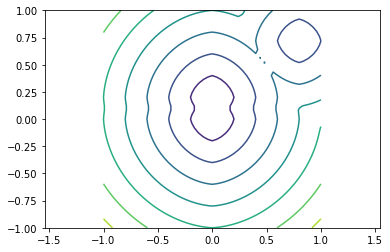

In [11]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].value);

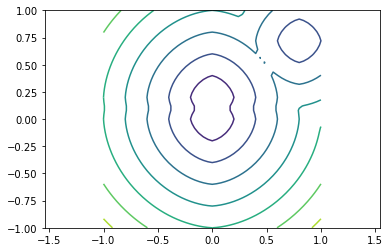

In [12]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient().sum(axis=0));

## 2. Reverse differentiation

In [13]:
n=50
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':cp.array([[0.,0.],[0.,0.5]]),
#    'seeds':cp.array([[0.,0.],[0.8,0.7],[0.,0.2]]),
#    'seedValues':ad.array([0.*delta[0],0.2*(1.+delta[0]),0.*delta[0]]),
    'exportValues':1,
    'traits':{
        'shape_i':(8,8),'niter_i':16,
    },
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

Casting output of function zeros from float64 to float32
Casting output of function array from float64 to float32


In [14]:
sensShape= tuple(hfmIn['dims'].astype(int))+(1,)
sens = cp.zeros(sensShape)
sens[-1,-1] = 1.
hfmIn['sensitivity'] = sens

Casting output of function zeros from float64 to float32


In [15]:
hfmOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.00549769401550293 seconds,  and 11 iterations.
Post-Processing


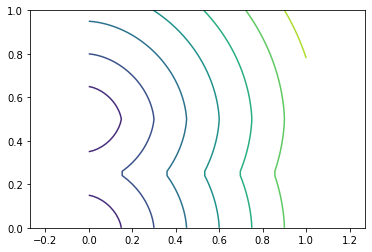

In [19]:
plt.axis('equal')
plt.contour(*X,hfmOut['values']);

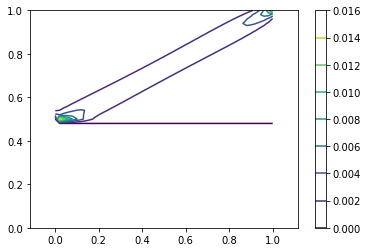

In [17]:
plt.axis('equal')
#cSens = hfmOut['costSensitivity'][0]; cSens[0,0]=0
plt.contour(*X,hfmOut['costSensitivity'][...,0]); plt.colorbar();

In [18]:
hfmOut['seedValueSensitivity'][...,0]

array([    0,     1], dtype=float32)